In [11]:
pip install numpy pandas tensorflow scikit-learn imbalanced-learn


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [12]:
# Essential libraries
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


Class distribution before balancing:
label
Non Demented          67222
Very mild Dementia    13725
Mild Dementia          5002
Moderate Dementia       488
Name: count, dtype: int64


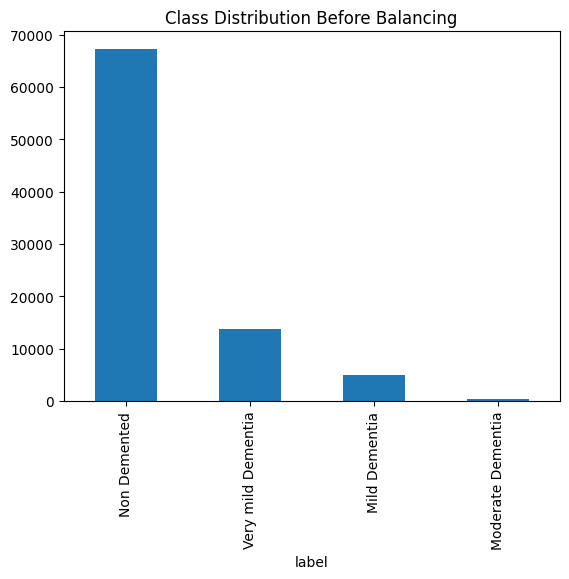

In [13]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load dataset paths and labels
data_dir = '/kaggle/input/srksaiteja'
file_paths = []
labels = []

# Collect file paths and labels
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.jpg') or file.endswith('.png'):
            file_paths.append(os.path.join(root, file))
            labels.append(root.split(os.path.sep)[-1])

# Create DataFrame
df = pd.DataFrame({'file_path': file_paths, 'label': labels})

# Encode labels into integers
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

# Check and plot class distribution before balancing
print("Class distribution before balancing:")
print(df['label'].value_counts())

# Plot class distribution
df['label'].value_counts().plot(kind='bar', title='Class Distribution Before Balancing')
plt.show()


label
Non Demented          67222
Very mild Dementia    67222
Moderate Dementia     67222
Mild Dementia         67222
Name: count, dtype: int64


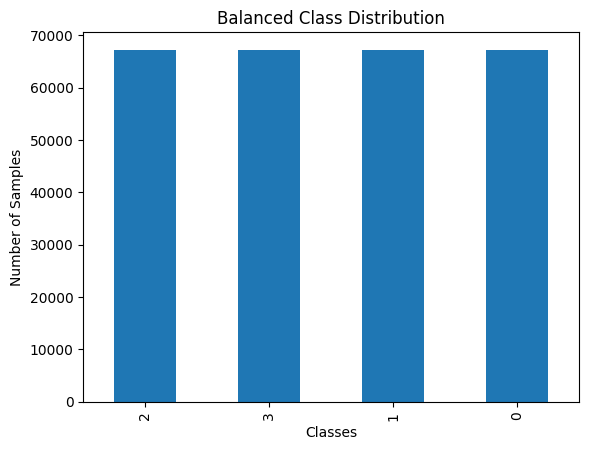

In [14]:
# Encode labels into integer values
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

# Use RandomOverSampler to balance the classes
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df[['file_path']], df['label_encoded'])

# Create a balanced DataFrame
balanced_df = pd.DataFrame({'file_path': X_resampled['file_path'], 'label_encoded': y_resampled})

# Decode labels for easy interpretation
balanced_df['label'] = le.inverse_transform(balanced_df['label_encoded'])
balanced_counts = balanced_df['label'].value_counts()
# Plot the new balanced class distribution
print(balanced_counts)
balanced_df['label_encoded'].value_counts().plot(kind='bar')
plt.title('Balanced Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.show()


In [15]:
# Split the balanced dataset into train, validation, and test sets
train_val_df, test_df = train_test_split(balanced_df, test_size=0.15, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

# Check the number of samples in each set
print(f"Training set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")


Training set: 182843 samples
Validation set: 45711 samples
Test set: 40334 samples


In [16]:
# Define ImageDataGenerator for training (with augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Define ImageDataGenerator for validation and test (without augmentation)
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Prepare data generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='file_path',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_generator = test_val_datagen.flow_from_dataframe(
    val_df,
    x_col='file_path',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_val_datagen.flow_from_dataframe(
    test_df,
    x_col='file_path',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important: don't shuffle test data
)


Found 182843 validated image filenames belonging to 4 classes.
Found 45711 validated image filenames belonging to 4 classes.
Found 40334 validated image filenames belonging to 4 classes.


In [17]:
# Define a simple CNN model
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes for Alzheimer's stages
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model architecture
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 524,324 (2.00 MB)

 Trainable params: 524,324 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Add early stopping to monitor validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Adjust epochs as needed
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[early_stopping]
)


Epoch 1/10
5713/5713 ━━━━━━━━━━━━━━━━━━━━ 1253s 219ms/step - accuracy: 0.8101 - loss: 0.4569 - val_accuracy: 0.8727 - val_loss: 0.3061
Epoch 2/10
5713/5713 ━━━━━━━━━━━━━━━━━━━━ 0s 5us/step - accuracy: 0.8750 - loss: 0.4184 - val_accuracy: 0.8667 - val_loss: 0.1879
Epoch 3/10


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


5713/5713 ━━━━━━━━━━━━━━━━━━━━ 1219s 213ms/step - accuracy: 0.8443 - loss: 0.3853 - val_accuracy: 0.8974 - val_loss: 0.2568
Epoch 4/10
5713/5713 ━━━━━━━━━━━━━━━━━━━━ 0s 5us/step - accuracy: 0.8438 - loss: 0.4075 - val_accuracy: 0.8667 - val_loss: 0.1752
Epoch 5/10
5713/5713 ━━━━━━━━━━━━━━━━━━━━ 1258s 220ms/step - accuracy: 0.8632 - loss: 0.3465 - val_accuracy: 0.9005 - val_loss: 0.2502
Epoch 6/10
5713/5713 ━━━━━━━━━━━━━━━━━━━━ 0s 6us/step - accuracy: 0.7812 - loss: 0.4386 - val_accuracy: 0.8667 - val_loss: 0.4044
Epoch 7/10
5713/5713 ━━━━━━━━━━━━━━━━━━━━ 1385s 242ms/step - accuracy: 0.8764 - loss: 0.3164 - val_accuracy: 0.9010 - val_loss: 0.2505
Epoch 8/10
5713/5713 ━━━━━━━━━━━━━━━━━━━━ 0s 5us/step - accuracy: 0.9688 - loss: 0.2067 - val_accuracy: 0.8667 - val_loss: 0.5034
Epoch 9/10
5713/5713 ━━━━━━━━━━━━━━━━━━━━ 1314s 230ms/step - accuracy: 0.8872 - loss: 0.2911 - val_accuracy: 0.9143 - val_loss: 0.2236


In [38]:
from sklearn.metrics import classification_report  
test_generator = test_val_datagen.flow_from_dataframe(
    test_df,
    x_col='file_path',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Get predictions for the test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Print the classification report
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))







1261/1261 ━━━━━━━━━━━━━━━━━━━━ 72s 57ms/step
                    precision    recall  f1-score   support

     Mild Dementia       0.89      0.97      0.93     10038
 Moderate Dementia       0.99      1.00      1.00     10083
      Non Demented       0.92      0.78      0.84     10050
Very mild Dementia       0.81      0.86      0.83     10163

          accuracy                           0.90     40334
         macro avg       0.90      0.90      0.90     40334
      weighted avg       0.90      0.90      0.90     40334



In [54]:

print(le.classes_)




['Mild Dementia' 'Moderate Dementia' 'Non Demented' 'Very mild Dementia']


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction Probabilities for /kaggle/input/srksaiteja/Data/Non Demented/OAS1_0001_MR1_mpr-1_104.jpg: [[3.9101649e-02 3.6267522e-08 5.1058257e-01 4.5031577e-01]]


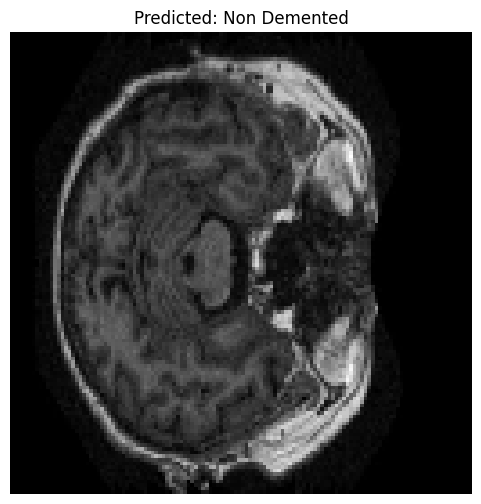

Predicted Stage: Non Demented

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction Probabilities for /kaggle/input/srksaiteja/Data/Mild Dementia/OAS1_0028_MR1_mpr-1_106.jpg: [[6.0672128e-01 3.2117314e-12 1.1995013e-01 2.7332860e-01]]


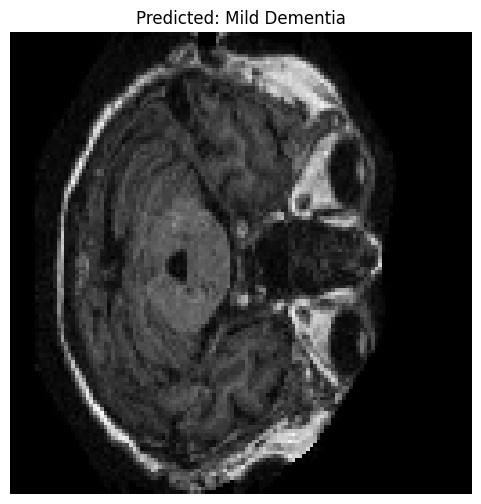

Predicted Stage: Mild Dementia

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction Probabilities for /kaggle/input/srksaiteja/Data/Moderate Dementia/OAS1_0308_MR1_mpr-1_107.jpg: [[7.5777166e-16 9.9999738e-01 1.2111465e-06 1.4492817e-06]]


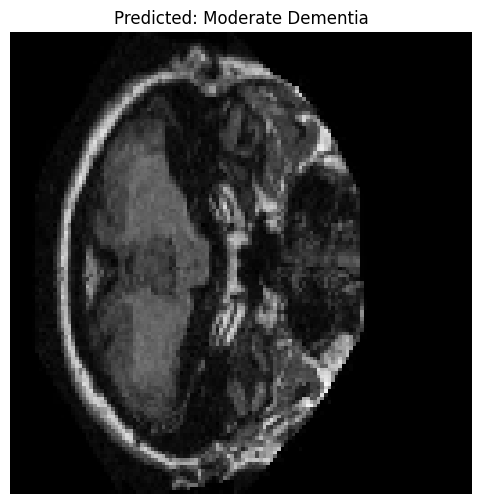

Predicted Stage: Moderate Dementia

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction Probabilities for /kaggle/input/srksaiteja/Data/Very mild Dementia/OAS1_0003_MR1_mpr-1_102.jpg: [[0.00174184 0.1099062  0.15152475 0.7368272 ]]


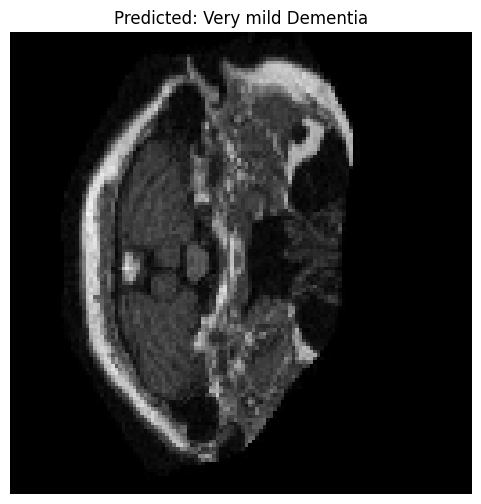

Predicted Stage: Very mild Dementia



In [64]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np

# Define each image path individually as separate strings in the list
img_paths = [
    '/kaggle/input/srksaiteja/Data/Non Demented/OAS1_0001_MR1_mpr-1_104.jpg',  # Image path 1
    '/kaggle/input/srksaiteja/Data/Mild Dementia/OAS1_0028_MR1_mpr-1_106.jpg',      # Image path 2
    '/kaggle/input/srksaiteja/Data/Moderate Dementia/OAS1_0308_MR1_mpr-1_107.jpg' ,
    '/kaggle/input/srksaiteja/Data/Very mild Dementia/OAS1_0003_MR1_mpr-1_102.jpg'# Image path 3
]

# Iterate through each image path to process and predict
for img_path in img_paths:
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(128, 128))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0

        # Make predictions
        predictions = model.predict(img_array)
        print(f'Prediction Probabilities for {img_path}: {predictions}')

        # Get the predicted class and label
        predicted_class = np.argmax(predictions, axis=1)
        predicted_label = le.inverse_transform(predicted_class)[0]

        # Display the image and prediction
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title(f'Predicted: {predicted_label}')
        plt.axis('off')
        plt.show()

        print(f'Predicted Stage: {predicted_label}\n')
        
    except Exception as e:
        print(f"Error with image at path {img_path}: {e}")


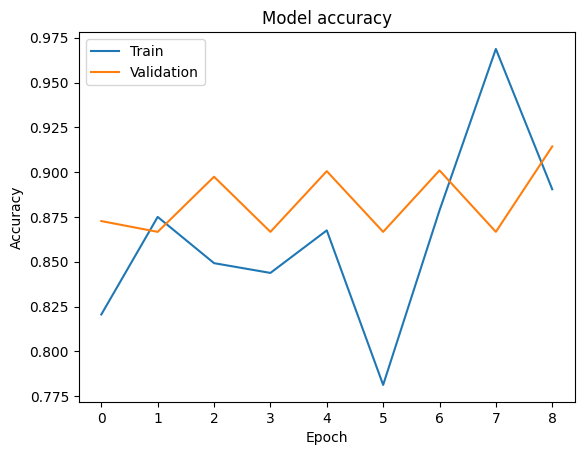

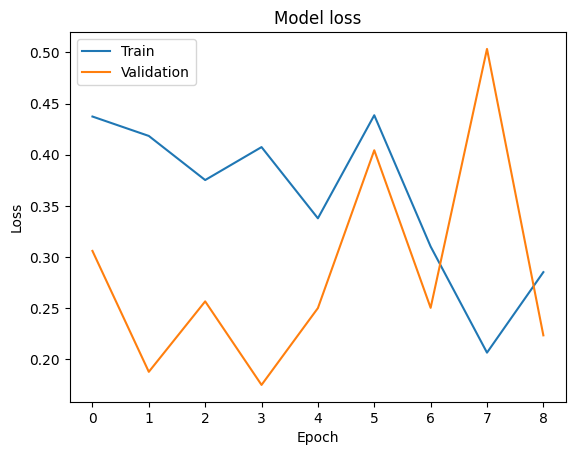

In [65]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [67]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Generate predictions on the test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get predicted class indices

# True labels
y_true = test_generator.classes

# Calculate test accuracy
test_accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")



# Confusion matrix



1261/1261 ━━━━━━━━━━━━━━━━━━━━ 87s 69ms/step
Test Accuracy: 90.09%


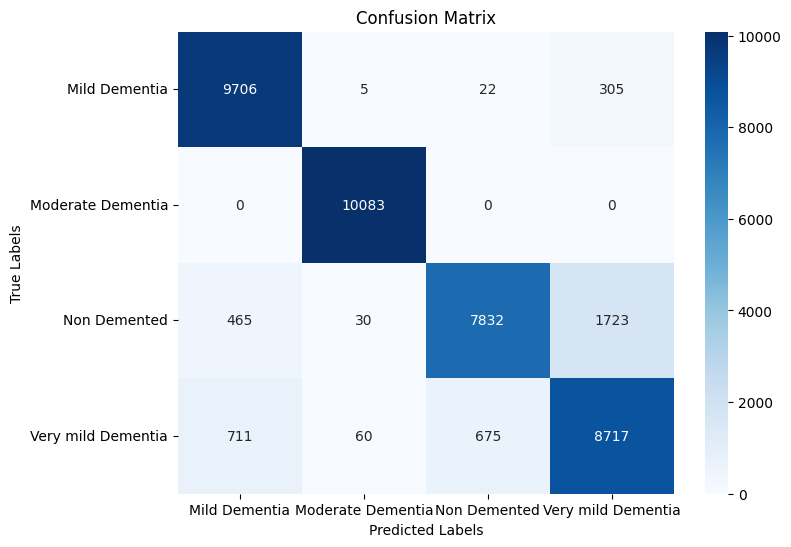

In [68]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()